# Exploration of Dask

In [1]:
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT
from dask import dataframe as ddf

In [2]:
PATH = '/scratch/students/justine/'
FILE = 's3-impresso-stats'

In [3]:
test_df = ddf.read_csv(
    PATH+FILE+"/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

## Explore dataframe

### Snapshots

In [4]:
test_df.head(5)

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN


In [5]:
test_df.tail(5)

,id,year,newspaper,type,n_tokens,title_length
173,waeschfra-1884-07-05-a-i0017,1884,waeschfra,ar,19.0,NaN
174,waeschfra-1884-07-05-a-i0018,1884,waeschfra,img,NaN,NaN
175,waeschfra-1884-07-05-a-i0019,1884,waeschfra,img,NaN,NaN
176,waeschfra-1884-07-05-a-i0020,1884,waeschfra,img,NaN,NaN
177,waeschfra-1884-07-05-a-i0021,1884,waeschfra,img,NaN,NaN


In [7]:
%time test_df.head(1000,npartitions=3)

CPU times: user 3.21 s, sys: 603 ms, total: 3.81 s
Wall time: 2.12 s


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
538,BNN-1886-01-30-a-i0017,1886,BNN,ar,102.0,14.0
539,BNN-1886-01-30-a-i0018,1886,BNN,ar,136.0,35.0
540,BNN-1886-01-30-a-i0019,1886,BNN,ar,8.0,13.0
541,BNN-1886-01-30-a-i0020,1886,BNN,ar,39.0,19.0


### Info in the type column

In [8]:
%time test_df.type.unique().compute()

CPU times: user 3min 4s, sys: 5min 36s, total: 8min 40s
Wall time: 1min 25s


0         ar
1        img
2         ad
3    section
4    picture
5       page
6         tb
7         ob
8          w
Name: type, dtype: object

### Try filtering

In [9]:
%%time 
BDC_ar_df = test_df[(test_df.newspaper=='BDC') & (test_df.type=='ar')].compute()

CPU times: user 3min 15s, sys: 5min 57s, total: 9min 13s
Wall time: 1min 18s


## Statistics

### Number of rows

In [10]:
%time test_df.shape[0].compute()

CPU times: user 3min 2s, sys: 5min 47s, total: 8min 49s
Wall time: 1min 10s


47876994

### Number of content items per np

In [11]:
count_rows_np = test_df.groupby('newspaper').id.count()

In [12]:
%%time 
count_rows_np_pd = count_rows_np.compute()

CPU times: user 3min 44s, sys: 8min, total: 11min 44s
Wall time: 1min 19s


In [13]:
count_rows_np_pd

newspaper
BDC                 146
BLB                 429
BNN               50500
CDV               16939
CON                2842
                  ...  
schmiede           2940
tageblatt        993158
volkfreu1869      34410
waechtersauer     37123
waeschfra         19953
Name: id, Length: 76, dtype: int64

### Join with issues table

#### Create column issue id

In [4]:
test_df['issue_id'] = test_df.id.apply(lambda x: x[:x.rfind("-")], meta=str)

In [5]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a


#### Join with issues table

In [10]:
from sql import db_engine, read_table

In [11]:
engine = db_engine()
issues_df = read_table('impresso.issues', engine)
issues_df = issues_df.rename(columns={"id": "issue_id"})

In [12]:
issues_df.head()

,issue_id,year,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id
0,actionfem-1927-10-15-a,1927,10,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
1,actionfem-1927-11-15-a,1927,11,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
2,actionfem-1927-12-15-a,1927,12,15,a,Closed,2019-06-15 12:22:38,NaT,0,,actionfem
3,actionfem-1928-01-15-a,1928,1,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem
4,actionfem-1928-02-15-a,1928,2,15,a,Closed,2019-06-15 12:22:41,NaT,0,,actionfem


In [13]:
ar_content_item = test_df.merge(issues_df, on='issue_id', suffixes=('_ci', '_issue'))

In [14]:
ar_content_item.head(3)

,id,year_ci,newspaper,type,n_tokens,title_length,issue_id,year_issue,month,day,edition,access_rights,created,last_modified,is_damaged,s3_version,newspaper_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a,1839,1,20,a,OpenPublic,2019-06-17 11:53:25,NaT,0,,BDC


#### Clean & keep only useful columns

In [15]:
ar_content_item = ar_content_item[['id', 'newspaper_id', 'type', 'n_tokens', 'year_issue', 'month', 'day', \
                                   'access_rights']].rename(columns={'year_issue':'year'})

In [16]:
ar_content_item.head()

,id,newspaper_id,type,n_tokens,year,month,day,access_rights
0,BDC-1839-01-20-a-i0001,BDC,ar,250.0,1839,1,20,OpenPublic
1,BDC-1839-01-20-a-i0002,BDC,ar,758.0,1839,1,20,OpenPublic
2,BDC-1839-01-20-a-i0003,BDC,ar,14.0,1839,1,20,OpenPublic
3,BDC-1839-01-20-a-i0004,BDC,ar,349.0,1839,1,20,OpenPublic
4,BDC-1839-01-20-a-i0005,BDC,ar,193.0,1839,1,20,OpenPublic


In [23]:
%time ar_content_item.shape[0].compute()

CPU times: user 27min 4s, sys: 1h 4min, total: 1h 31min 4s
Wall time: 5min 32s


33707113

#### Add decade column

In [17]:
from helpers import decade_from_year_df
ar_content_item = decade_from_year_df(ar_content_item, dask_df = True)

In [18]:
ar_content_item.head()

,id,newspaper_id,type,n_tokens,year,month,day,access_rights,decade
0,BDC-1839-01-20-a-i0001,BDC,ar,250.0,1839,1,20,OpenPublic,1830
1,BDC-1839-01-20-a-i0002,BDC,ar,758.0,1839,1,20,OpenPublic,1830
2,BDC-1839-01-20-a-i0003,BDC,ar,14.0,1839,1,20,OpenPublic,1830
3,BDC-1839-01-20-a-i0004,BDC,ar,349.0,1839,1,20,OpenPublic,1830
4,BDC-1839-01-20-a-i0005,BDC,ar,193.0,1839,1,20,OpenPublic,1830


#### Number of content-item per access right

In [24]:
%%time
ar_per_CI = ar_content_item[['id', 'access_rights']].groupby('access_rights').id.count().compute()

CPU times: user 28min 28s, sys: 1h 7min 22s, total: 1h 35min 51s
Wall time: 5min 34s


In [25]:
ar_per_CI

access_rights
OpenPublic      1427254
OpenPrivate    29158736
Closed          3121123
Name: id, dtype: int64

## Filter content item dataframe

### Test filter function with several parameters on dask df

In [19]:
from helpers import filter_df

In [20]:
ar_content_item_sub,_ = filter_df(ar_content_item, np_ids=['GDL', 'NZZ', 'JDG'], start_date=1780, end_date=1810)

Following cell takes 7min to run : outputs 24'294 >> can be converted to pandas df

In [21]:
%time ar_content_item_sub.shape[0].compute()

CPU times: user 30min 53s, sys: 1h 17min 40s, total: 1h 48min 34s
Wall time: 7min 25s


24294

In [25]:
ar_content_item_sub_pd = ar_content_item_sub.compute()

In [26]:
ar_content_item_sub_pd

,id,newspaper_id,type,n_tokens,year,month,day,access_rights,decade
0,GDL-1798-02-01-a-i0001,GDL,ar,213.0,1798,2,1,OpenPrivate,1790
1,GDL-1798-02-01-a-i0002,GDL,ar,8.0,1798,2,1,OpenPrivate,1790
2,GDL-1798-02-01-a-i0003,GDL,ar,184.0,1798,2,1,OpenPrivate,1790
3,GDL-1798-02-02-a-i0001,GDL,ar,173.0,1798,2,2,OpenPrivate,1790
4,GDL-1798-02-02-a-i0002,GDL,ar,7.0,1798,2,2,OpenPrivate,1790
...,...,...,...,...,...,...,...,...,...
17290,NZZ-1810-12-25-a-i0006,NZZ,page,1302.0,1810,12,25,Closed,1810
17291,NZZ-1810-12-28-a-i0001,NZZ,page,1007.0,1810,12,28,Closed,1810
17292,NZZ-1810-12-28-a-i0002,NZZ,page,1303.0,1810,12,28,Closed,1810
17293,NZZ-1810-12-28-a-i0003,NZZ,page,1271.0,1810,12,28,Closed,1810


In [30]:
from visualization import plot_licences

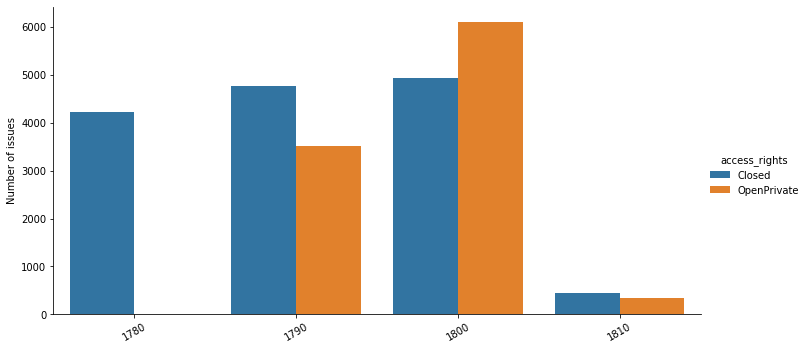

In [44]:
plot_licences(facet='time', df=ar_content_item_sub_pd)

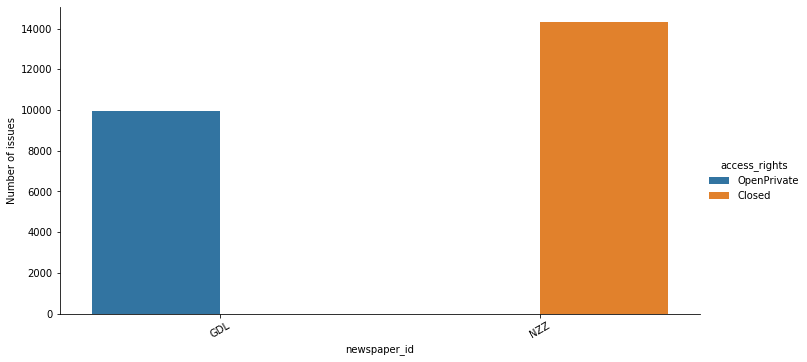

In [45]:
plot_licences(facet='newspapers', df=ar_content_item_sub_pd)

In [40]:
import pandas
from typing import Iterable

In [41]:
## TODO : FINISH THIS
def plot_licences_content_it(
    facet: str = 'newspapers',
    ddf: pandas.core.frame.DataFrame = None,
    start_date: int = None,
    end_date: int = None,
    np_ids: Iterable = None,
    country: str = None,
    batch_size: int = None,
    ppty: str = None,
    ppty_value: str = None,
) :
    
    ddf_sub,_ = filter_df(ddf, start_date, end_date, np_ids, country, ppty, ppty_value)
    #TODO : add condition on the size of teh df before calling compute()
    df = ddf_sub.compute()
    plot_licences(facet=facet, df=df)
    

## Others

In [66]:
def np_pd(ddf, npID: str, max_rows: int):
    if len(ddf.loc[ddf.newspaper == npID] < max_rows) :
        return ddf.loc[ddf.newspaper == npID].compute()
    else :
        print('Length of dataframe exceeds max_rows > cannot be converted to pandas df.')
        return None

In [35]:
def num_content_items(npID: str):
    return test_df.loc[test_df.newspaper == npID].count().compute()

In [37]:
def num_content_items2(npID: str):
    return test_df.filter(test_df.newspaper == npID).count().compute()

In [38]:
%time num_content_items2('BDC')

AttributeError: 'DataFrame' object has no attribute 'filter'

In [49]:
%time num_content_items('BLB')

CPU times: user 3min 23s, sys: 6min 52s, total: 10min 15s
Wall time: 1min 2s


id              429
year            429
newspaper       429
type            429
n_tokens        429
title_length    429
dtype: int64

In [26]:
%time test_df.loc[test_df.newspaper == 'BDC'].compute()

CPU times: user 3min 24s, sys: 6min 44s, total: 10min 9s
Wall time: 1min 1s


,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN
...,...,...,...,...,...,...
7,BDC-1839-04-04-a-i0002,1839,BDC,ar,713.0,NaN
8,BDC-1839-04-04-a-i0003,1839,BDC,ar,773.0,NaN
9,BDC-1839-04-04-a-i0004,1839,BDC,ar,396.0,NaN
10,BDC-1839-04-04-a-i0005,1839,BDC,ar,336.0,NaN
